# Python code of Gibbs sampling model for family test result Covid problem

In [1]:
# import neccessary libraries
import numpy as np
import random
import sympy as sym
from sympy import *
from sympy import symbols
from sympy.plotting import plot, plot3d
from datetime import datetime
from scipy.stats import beta
from sklearn.metrics import accuracy_score
import winsound
import matplotlib.pyplot as plt
from scipy import spatial
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

duration = 1000  # milliseconds
freq = 440  # Hz


In [2]:
# function to count the number of the infected neighbores of i at t:
def CNbr(G,X,n,T):
    C=np.zeros((T,n))
    for t in range(T):
        C[t]=G[t].dot(X.T[t])
    return C.T

In [2]:
def transition(X,t,G,F,j,param):
    alpha_=param[0]
    beta_=param[1]
    betaf=param[2]
    gama_=param[3]
    c=CNbr(G,X,n,T)[j][t]
    number_of_infected_members_in_family=F.dot(X.T[t])[j]
    k=X[j,t]-2*X[j,t+1]
    if k==0:
        return 1-alpha_-beta_*c-betaf*number_of_infected_members_in_family
    elif k==-2:
        return alpha_+beta_*c+betaf*number_of_infected_members_in_family
    elif k==1:
        return gama_
    else:
        return 1-gama_
    

In [3]:
# Function to obtain the very initial sample of X, using forwad sampling:
def Forward_Sampling(T,n,G,F,param):
    alpha_=param[0]
    beta_=param[1]
    betaf=param[2]
    gama_=param[3]
    p0=P
    p1=1-P
    x=int(np.round(((1-P)*n),0))
    X=np.zeros((n,T))  
    idx=np.random.choice(range(n), x)
    X[idx,0]=1
    for t in range(T-1):
        cf=F.dot(X.T[t])
        for i in range(n):
            c=CNbr(G,X,n,T)[i,t]
            if X[i,t]==0:
                p1=(alpha_+beta_*c+betaf*cf[i])
            else:
                p1=(1-gama_)
            X[i,t+1]=np.random.binomial( 1, p1,size=None) 
    return X

In [4]:
def Sample_hidden_state(X,G,F,unique_rows,Y,param,t):
    
    alpha_=param[0]
    beta_=param[1]
    betaf=param[2]
    gama_=param[3]
    theta_0_=param[4]
    theta_1_=param[5]
    
    for i in range(n):
        if t==0:
            p_0,p_1=P,1-P
        else:
            p_0,p_1=1,1
        pow0=1-Y[i,t]
        pow1=Y[i,t]
        number_of_members_in_family=np.sum(unique_rows[family_index(i,unique_rows)])
        
        X[i,t]=0
        number_of_infected_members_in_family0=F.dot(X.T[t])[i]
        number_of_healthy_members_in_family0=number_of_members_in_family-number_of_infected_members_in_family0
        p_0=(1/number_of_members_in_family)*p_0*((1-theta_0_)*number_of_healthy_members_in_family0+(1-theta_1_)*number_of_infected_members_in_family0)**pow0*(theta_1_*number_of_infected_members_in_family0+theta_0_*number_of_healthy_members_in_family0)**pow1
        if (t==0):
            c=G[t].dot(X.T[t])[i]
        else:    
            c=G[t-1].dot(X.T[t-1])[i]
    
        if t!=0:
            if X[i,t-1]==0:
                p_0=p_0*(1-alpha_-beta_*c-betaf*number_of_infected_members_in_family0)
            else:
                p_0=p_0*gama_
        
        X[i,t]=1
        number_of_infected_members_in_family1=F.dot(X.T[t])[i]
        number_of_healthy_members_in_family1=number_of_members_in_family-number_of_infected_members_in_family1
        p_1=(1/number_of_members_in_family)*p_1*((1-theta_0_)*number_of_healthy_members_in_family1+(1-theta_1_)*number_of_infected_members_in_family1)**pow0*(theta_1_*number_of_infected_members_in_family1+theta_0_*number_of_healthy_members_in_family1)**pow1

        if (t==0):
            c=G[t].dot(X.T[t])[i]
        else:    
            c=G[t-1].dot(X.T[t-1])[i]
        if t!=0:
            if X[i,t-1]==0:
                p_1=p_1*(alpha_+beta_*c+betaf*number_of_infected_members_in_family1)
            else:
                p_1=p_1*(1-gama_)
        family_members=unique_rows[family_index(i,unique_rows)]
        
        if t!=T-1:        
            X[i,t]=0
            for j in np.where(family_members==1)[0]:
                if j!=i:
                    p_0=p_0*transition(X,t,G,F,j,param)
            for j in np.where(G[t][i]==1)[0]:
                p_0=p_0*transition(X,t,G,F,j,param)
            X[i,t]=1
            for j in np.where(family_members==1)[0]:
                if j!=i:
                    p_1=p_1*transition(X,t,G,F,j,param)
            for j in np.where(G[t][i]==1)[0]:
                p_1=p_1*transition(X,t,G,F,j,param)
        if t==T-1:
            if X[i,t-1]==0:
                X[i,t]=0
                c=G[t].dot(X.T[t])[i]
                number_of_infected_members_in_family=F.dot(X.T[t])[i]
                p_0=p_0*(1-alpha_-beta_*c-betaf*number_of_infected_members_in_family)
                X[i,t]=1
                c=G[t].dot(X.T[t])[i]
                number_of_infected_members_in_family=F.dot(X.T[t])[i]
                p_1=p_1*(alpha_+beta_*c+betaf*number_of_infected_members_in_family)
            else:
                p_0=p_0*gama_
                p_1=p_1*(1-gama_)
        if p_0+p_1==0:            
            l=0.5
        else:
            l=p_1/(p_0+p_1)
        if (l<0)|(l>1): 
            print(p_0,p_1)
        X[i,t]=np.random.binomial( 1,  l,size=None)    
        
    return X    

In [5]:
# Gibbs sampling to obtain X, as new sample of posterior distribution:
def Calculate_X(Z,K,T,X,G,F1,Y,param):
    accuracy=[]
    myList =[]
    for k in range(K):
        for t in range(T):
            hidden_states=Sample_hidden_state(X,G,F1,unique_rows,Y,param,t)
            X=hidden_states[0]
            pos_probs=hidden_states[1]
    return X  ,pos_probs              

In [6]:
def Accuracy_(X,X_):
    Xflat = np.hstack(np.hstack(X))
    X_flat = np.hstack(np.hstack(X_))
    result=accuracy_score(Xflat, X_flat,normalize=True)
    return result

# Functions to sample from beta distribution


In [8]:
# function to define auxiliary variable R_(n,t):
def R_(G,X,params):
    alpha_,beta_,betaf,gama_,theta_0_,theta_1_=params[0],params[1],params[2],params[3],params[4],params[5]
    infected_neighbore=np.array(CNbr(G,X,n,T))
    R=np.zeros((n,T))+1
    for i in range(n):
        for t in range(T-1):
            c=int(infected_neighbore[i,t])
            cf=int(F.dot(X.T[t])[i])
            pr_a=alpha_/(alpha_+beta_*c+betaf*cf)
            pr_b=beta_/(alpha_+beta_*c+betaf*cf)
            pr_bf=betaf/(alpha_+beta_*c+betaf*cf)
            v=np.random.multinomial(1, [pr_a]+[pr_b]*c+[pr_bf]*cf)
            if (X[i][t]==0)&(X[i][t+1]==1):
                if v[0]==1:
                    R[i,t]=0
                elif (cf!=0):
                    if ((v[-cf:]==1).any()):
                        R[i,t]=3
                else:    
                    R[i,t]=2
    return R

In [7]:
# function to sample new parameters and update parameters:
def Params(R,G,F,X,n,T,Y,hyper_param):
    
    a_alpha=hyper_params[0]
    b_alpha=hyper_params[1]
    a_beta=hyper_params[2]
    b_beta=hyper_params[3]
    a_betaf=hyper_params[4]
    b_betaf=hyper_params[5]
    a_gama=hyper_params[6]
    b_gama=hyper_params[7]
    a_teta0=hyper_params[8]
    b_teta0=hyper_params[9]
    a_teta1=hyper_params[10]
    b_teta1=hyper_params[11]
      
    TP=np.sum(np.multiply(unique_rows.dot(X),YF))
    FP=np.count_nonzero(unique_rows.dot(X)-YF==-1)
    
    infected_neighbore=np.array(CNbr(G,X,n,T))
    a_alpha, b_alpha=a_alpha +  np.count_nonzero(R==0) , b_alpha +np.count_nonzero(X==0)- np.count_nonzero(R==0)
    alpha_=Sample_alpha(a_alpha, b_alpha)
    a_beta,b_beta=a_beta + np.count_nonzero(R==2) , b_beta +np.sum(np.multiply((1-X),infected_neighbore))-np.count_nonzero(R==2)
    beta_=Sample_beta(a_beta,b_beta)
    a_betaf ,b_betaf=a_betaf + np.count_nonzero(R==3) , b_betaf +np.sum(np.multiply((1-X),F.dot(X)))-np.count_nonzero(R==3)
    betaf=Sample_betaf(a_betaf ,b_betaf)
    while alpha_>beta_:
        alpha_=Sample_alpha(a_alpha, b_alpha)
        beta_=Sample_beta(a_beta, b_beta)
    while beta_>betaf:
        betaf=Sample_betaf(a_betaf, b_betaf)
    gama_=Sample_gama(a_gama +np.count_nonzero((X[:,:-1]-X[:,1:])==1), b_gama+np.sum(X)-np.count_nonzero((X[:,:-1]-X[:,1:])==1))
    theta_0_=Sample_theta0( a_teta0+FP,b_teta0+np.count_nonzero((unique_rows.dot(X))==0)-FP)
    theta_1_=Sample_theta1( a_teta1+TP,b_teta1+np.sum(unique_rows.dot(X))-TP)
    
    R=R_(G,X,params)
    param=[alpha_,beta_,betaf,gama_,theta_0_,theta_1_]
    return param,R

In [9]:
def Sample_alpha(a_alpha, b_alpha):
    for i in beta.rvs(a_alpha, b_alpha, size=10000):
        if (i>0.001)&(i<0.2):
            alpha_=round(i,3)
            break
    return alpha_        


In [10]:
def Sample_beta(a_beta, b_beta):
    for i in beta.rvs(a_beta, b_beta, size=10000):
        if (i>0.001)&(i<0.0451):
            beta_=round(i,4)
            break
    return beta_        

In [11]:
def Sample_betaf(a_betaf, b_betaf):
    for i in beta.rvs(a_betaf, b_betaf, size=1000):
        if (i>0.002)&(i<0.5):
            betaf=round(i,4)
            break
    return betaf        

In [12]:
def Sample_gama(a_gama,b_gama):
    for i in beta.rvs(a_gama, b_gama, size=10000):
        if (i>0.1)&(i<0.5):
            gama_=round(i,3)
            break
    return gama_  

In [13]:
def Sample_theta0(a_teta0, b_teta0):
    for i in beta.rvs(a_teta0, b_teta0, size=10000):
        if (i>0.01)&(i<0.51):
            theta_0_=round(i,3)
            break
    return theta_0_  

In [14]:
def Sample_theta1(a_teta1, b_teta1):
    for i in beta.rvs(a_teta1, b_teta1, size=10000):
        if 0.990>i>0.78:
            theta_1_=round(i,3)
            break
    return theta_1_  

In [15]:
def add_noise(YF,noise_percent,unique_rows):
    
    number_of_families=unique_rows.shape[0]
    indx=random.sample(range(number_of_families), number_of_families)
    tndx=random.sample(range(T), int(noise_percent*T))
    for i in indx:
        for t in tndx:
            YF[i,t]=(YF[i,t]+1)*(1-YF[i,t])
    return YF        

In [16]:
# funtion to retun related family index of individual i:
def family_index(i,unique_rows):
    for j in range(n):
        if unique_rows[j,i]==1:
            return j

In [16]:
# Function to generates Synthetic dataset
def Synthetic_Data(n,T,y,params,number_families):
    alpha_,beta_,betaf,gama_,theta_0_,theta_1_=params[0],params[1],params[2],params[3],params[4],params[5]
    x=int(np.round(((1-P)*n),0))
    X=np.zeros((n,T))
    idx=np.random.choice(range(n), x)
    X[idx,0]=1
    # Random social network
    G=[]
    for j in range(T):
        g=np.identity(n,dtype=int)
        for i in range(n):
            indx=np.random.choice(range(i,n), y)
            for inx in indx:
                g[i,inx]=1  
                g[inx,i]=1
        G.append(g)
    G=np.array(G)
    # Synthetize Family matrix:
    a=list(range(n))
    Family=np.identity(n,dtype=int)
    for i in range(1,number_families):
        number_family_members=np.random.randint(2, 5)
        inx=random.sample(list(a), number_family_members)
        a=set(a).difference(inx)
        for j in inx:
            for k in inx:
                Family[j,k]=1  
    G=G-Family
    G=G+np.identity(n,dtype=int)
    #Family=Family-np.identity(n,dtype=int)
    G = np.where(G <0, 0, G)
    # Synthetize X, using params,G, Family and transition probability:
    #Family=Family+np.identity(n,dtype=int)
    for t in range(T-1):
        for i in range(n):
            infR=CNbr(G,X,n,T)
            cf=int(Family.dot(X.T[t])[i])
            c=infR[i,t]
            if X[i,t]==0:
                p0=1-alpha_-beta_*c-betaf*cf
                p1=alpha_+beta_*c+betaf*cf
            else:
                p0=gama_
                p1=1-gama_
            if p0+p1==0:
                l=0.5
            else:
                l=p1/(p0+p1)
            X[i,t+1]=np.random.binomial( 1, l,size=None) 

    # Synthetize Y, using params,G, X, emission probability:
    unique_rows = np.unique(Family, axis=0)
    nf=unique_rows.shape[0]
    YF=np.zeros((nf,T))
    for t in range(T):
        for i in range(nf):
            number_of_members_in_family=np.sum(unique_rows[i])
            number_of_infected_members_in_family=unique_rows[i].dot(X.T[t])
            number_of_healthy_members_in_family= number_of_members_in_family-number_of_infected_members_in_family
            py1=(theta_0_*number_of_healthy_members_in_family+theta_1_*number_of_infected_members_in_family)/ number_of_members_in_family
            py0=((1-theta_0_)*number_of_healthy_members_in_family+(1-theta_1_)*number_of_infected_members_in_family)/ number_of_members_in_family
            l=py1/(py1+py0)
            YF[i,t]=np.random.binomial( 1, l,size=None) 
    return G,YF,X,Family           

In [17]:
# initialize parameters for beta distributions:
a_alpha=20
b_alpha=1000
a_beta=10
b_beta=1000
a_betaf=8
b_betaf=80
a_gama=50
b_gama=200
a_teta0=10
b_teta0=1000
a_teta1=9000
b_teta1=300
P=1

In [18]:
#Sample infection and emision parameters(alpha,beta,gama,teta0,teta1)
def initialize_parameters(a_alpha,b_alpha,a_beta,b_beta,a_betaf,b_betaf,a_gama,b_gama,a_teta0,b_teta0,a_teta1,b_teta1):
    alpha_=Sample_alpha(a_alpha, b_alpha)
    beta_=Sample_beta(a_beta, b_beta)
    betaf=Sample_betaf(a_betaf, b_betaf)
    gama_=Sample_gama(a_gama,b_gama)
    theta_0_=Sample_theta0(a_teta0, b_teta0)
    theta_1_=Sample_theta1(a_teta1, b_teta1)
    params=np.array([alpha_,beta_,betaf,gama_,theta_0_,theta_1_])
    return params

In [19]:
params=initialize_parameters(a_alpha,b_alpha,a_beta,b_beta,a_betaf,b_betaf,a_gama,b_gama,a_teta0,b_teta0,a_teta1,b_teta1)
params

array([0.022 , 0.0104, 0.0722, 0.18  , 0.011 , 0.968 ])

In [39]:
# Generate synthetic data,G ,Y:
n,T,y=100,100,5
number_families=33
synthetic_data=Synthetic_Data(n,T,y,params,number_families)
G,YF,X,Family =synthetic_data[0],synthetic_data[1],synthetic_data[2],synthetic_data[3]

In [40]:
# Save true value of X in Z, as the correct label of data:
Z=X
np.sum(Z)

1387.0

In [41]:
F=Family

In [42]:
unique_rows = np.unique(F.T, axis=0)

# Adding noise to YF:

In [43]:
%store YF
%store params

Stored 'YF' (ndarray)
Stored 'params' (ndarray)


In [44]:
noise_percent=.1
YF_noisey=add_noise(YF,noise_percent,unique_rows)

In [45]:
Y=np.zeros((n,T))
for i in range(n):
    for j in range(unique_rows.shape[0]):
        if unique_rows[j,i]==1:
            Y[i,:]=YF[j,:]

In [46]:
U=10
K=10
J=10

In [47]:
# define auxiliary variable R(n,t):
alpha_,beta_,betaf,gama_,theta_0_,theta_1_=params[0],params[1],params[2],params[3],params[4],params[5]
infR=np.array(CNbr(G,X,n,T))
R=np.zeros((n,T))+1
for i in range(n):
    for t in range(T-1):
        infr=int(infR[i,t])
        cf=int(F.dot(X.T[t])[i])
        pr_a=alpha_/(alpha_+beta_*infr+betaf*cf)
        pr_b=beta_/(alpha_+beta_*infr+betaf*cf)
        pr_bf=betaf/(alpha_+beta_*infr+betaf*cf)
        v=np.random.multinomial(1, [pr_a]+[pr_b]*infr+[pr_bf]*cf)
        if (X[i][t]==0)&(X[i][t+1]==1):
            if v[0]==1:
                R[i,t]=0
            elif (cf!=0):
                if ((v[-cf:]==1).any()):
                    R[i,t]=3
            else:    
                R[i,t]=2


Forward_Sampling 0 
 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]
Start Gibbs Sampling:
************************************************ Iteration 0 ************************************************
Current Parameters: [0.017  0.0101 0.0651 0.19   0.02   0.966 ]
Current Time is : 18:00:29
Accuracy: 0.8538
************************************************ Iteration 1 ************************************************
Current Parameters: [0.013, 0.014, 0.1722, 0.233, 0.117, 0.959]
Current Time is : 18:01:53
Accuracy: 0.8627
************************************************ Iteration 2 ************************************************
Current Parameters: [0.01, 0.0272, 0.1113, 0.262, 0.153, 0.964]
Current Time is : 18:03:14
Accuracy: 0.8614
************************************************ Iteration 3 ************************************************
Current Parameters: [0.004, 0.0054,

Accuracy: 0.8611
************************************************ Iteration 4 ************************************************
Current Parameters: [0.004, 0.0125, 0.0978, 0.193, 0.162, 0.967]
Current Time is : 18:48:46
Accuracy: 0.8615
************************************************ Iteration 5 ************************************************
Current Parameters: [0.003, 0.011, 0.0667, 0.195, 0.162, 0.966]
Current Time is : 18:50:07
Accuracy: 0.8613
************************************************ Iteration 6 ************************************************
Current Parameters: [0.002, 0.012, 0.1015, 0.234, 0.162, 0.966]
Current Time is : 18:51:29
Accuracy: 0.8611
************************************************ Iteration 7 ************************************************
Current Parameters: [0.001, 0.0094, 0.0854, 0.221, 0.173, 0.968]
Current Time is : 18:52:53
Accuracy: 0.8613
************************************************ Iteration 8 ************************************************

Accuracy: 0.8616
************************************************ Iteration 9 ************************************************
Current Parameters: [0.003, 0.0123, 0.0862, 0.237, 0.167, 0.971]
Current Time is : 19:37:45
Accuracy: 0.8611
Current Time is : 19:39:05
Forward_Sampling 7 
 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 1. 1. ... 0. 0. 0.]]
Start Gibbs Sampling:
************************************************ Iteration 0 ************************************************
Current Parameters: [0.021  0.0102 0.0598 0.229  0.013  0.97  ]
Current Time is : 19:39:05
Accuracy: 0.8495
************************************************ Iteration 1 ************************************************
Current Parameters: [0.002, 0.002, 0.0049, 0.267, 0.091, 0.952]
Current Time is : 19:40:24
Accuracy: 0.8624
************************************************ Iteration 2 ***************************************

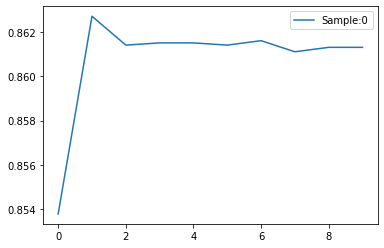

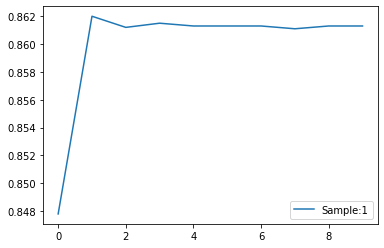

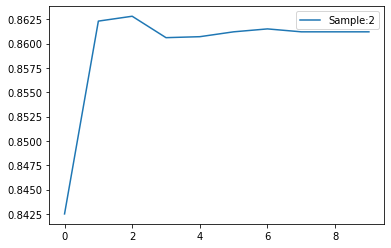

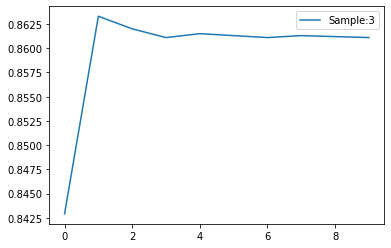

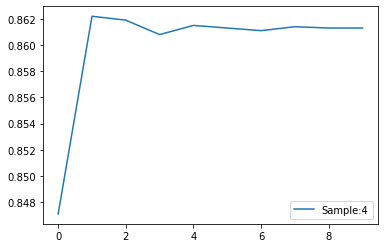

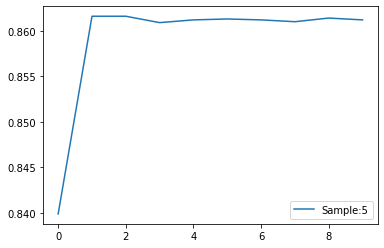

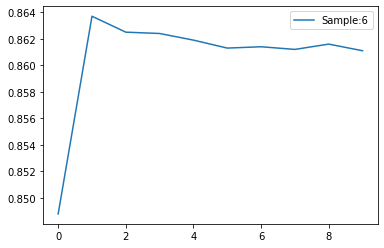

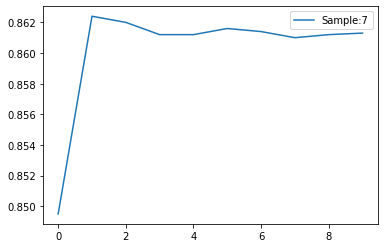

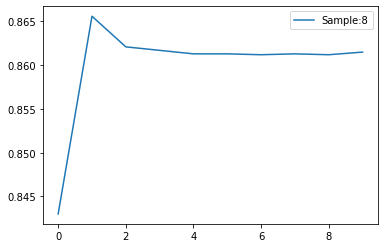

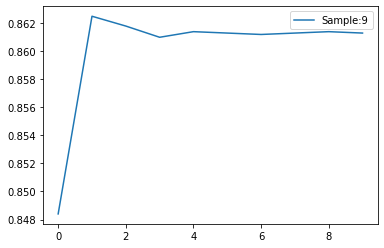

In [48]:
# Main code to run entire Gibbs algorithm U times:
Zflat = np.hstack(Z)
XX=[]
for j in range(J):
    params=initialize_parameters(a_alpha,b_alpha,a_beta,b_beta,a_betaf,b_betaf,a_gama,b_gama,a_teta0,b_teta0,a_teta1,b_teta1)
    #params=np.array([0.019 , 0.0118, 0.0841, 0.173 , 0.014 , 0.97  ])
    X=Forward_Sampling(T,n,G,F,params)
    #X=Z
    print("Forward_Sampling",j,"\n","\n",X)
    print("Start Gibbs Sampling:")
    mylist=[]
    accuracy=[]
    for i in range(U):
        print("************************************************ Iteration",i,"************************************************")
        print("Current Parameters:",params)
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time is :", current_time)
        X=Calculate_X(Z,K,T,X,G,F,Y,params)
        prm=Params(R,G,F,X,n,T,Y,params)
        params=prm[0]
        R=prm[1]
        Xflat = np.hstack(X)
    #result = 1 - spatial.distance.cosine(Zflat, Xflat)
        result=accuracy_score(Xflat, Zflat,normalize=True)
        print("Accuracy:",result)
        accuracy.append(result)
    XX.append(X)    
    myList = list(range(U))
    iteration=np.array(myList)
    Accuracy=np.array(accuracy)
    label="Sample:"+str(j)
    plt.figure()
    plt.plot(iteration,Accuracy,label=label ) 
    plt.legend()
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time is :", current_time)
winsound.Beep(freq, duration) 

In [49]:
def estimate_Y(Family,X,params):
    theta_0=params[4]
    theta_1=params[5]
    unique_rows = np.unique(Family, axis=0)
    nf=unique_rows.shape[0]
    YF=np.zeros((nf,T))
    for t in range(T):
        for i in range(nf):
            number_of_members_in_family=np.sum(unique_rows[i])
            number_of_infected_members_in_family=unique_rows[i].dot(X.T[t])
            number_of_healthy_members_in_family= number_of_members_in_family-number_of_infected_members_in_family
            py1=(theta_0_*number_of_healthy_members_in_family+theta_1_*number_of_infected_members_in_family)/ number_of_members_in_family
            py0=((1-theta_0_)*number_of_healthy_members_in_family+(1-theta_1_)*number_of_infected_members_in_family)/ number_of_members_in_family
            l=py1/(py1+py0)
            YF[i,t]=np.random.binomial( 1, l,size=None)
    return YF

In [ ]:
YF_=estimate_Y(F,X,params)

In [ ]:
%store -r YF

In [ ]:
Zflat = np.hstack(YF_noisey)
Xflat = np.hstack(YF)
result = 1 - spatial.distance.cosine(Zflat, Xflat)
print("Accuracy",result)


In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(Xflat, Zflat,normalize=True))

In [ ]:
YF

In [ ]:
YF_noisey

In [ ]:
# synthetized observation vectore:
Y_=np.zeros((n,T))
for t in range(T):
    for i in range(n):
        if X[i,t]==0:
            Y_[i,t]=np.random.binomial( 1, theta_0_,size=None) 
        else:
            Y_[i,t]=np.random.binomial( 1, theta_1_,size=None) 

In [ ]:
print(np.sum(X),np.sum(Z),np.count_nonzero(X-Z))

In [ ]:
# Run Gibbs sampling algorithm to estimate X:
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time is:", current_time)
print("Current Parameters:",params)
X=Forward_Sampling(T,n,G,F,params)
print("forward_sampling:\n",X)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start gibbs sampling: \n Current Time is:", current_time)
Zflat = np.hstack(Z)
Xflat = np.hstack(X)
result = 1 - spatial.distance.cosine(Zflat, Xflat)
print(np.sum(X))
print("Accuracy:",result)
X=Calculate_X(Z,K,T,X,G+np.identity(n,dtype=int),F,Y,params)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time is :", current_time)
print("Gibbs_sampling\n",X)
winsound.Beep(freq, duration)

In [ ]:
Y=Y_

# The following is for family test result problem:

In [ ]:
# Synthetize data for famity test result problem

In [ ]:
def Sample_alpha(a_alpha, b_alpha):
    for i in beta.rvs(a_alpha, b_alpha, size=1000):
        if (i>0.029)&(i<0.051):
            alpha_=round(i,3)
            break
    return alpha_        


In [ ]:
def Sample_beta(a_beta, b_beta):
    for i in beta.rvs(a_beta, b_beta, size=10000):
        if (i>0.00491)&(i<0.01451):
            beta_=round(i,4)
            break
    return beta_        


In [ ]:
def Sample_gama(a_gama,b_gama):
    for i in beta.rvs(a_gama, b_gama, size=1000):
        if (i>0.291)&(i<0.31):
            gama_=round(i,3)
            break
    return gama_  


In [ ]:
def Sample_theta0(a_teta0, b_teta0):
    for i in beta.rvs(a_teta0, b_teta0, size=10000):
        print(i)
        if (i<0.19975):
            theta_0_=round(i,3)
            break
    return theta_0_  


In [ ]:
def Sample_theta1(a_teta1, b_teta1):
    for i in beta.rvs(a_teta1, b_teta1, size=100000):
        if .9901>i>0.8:
            theta_1_=round(i,3)
            break
    return theta_1_  


In [ ]:
# initialize parameters for beta distributions:
a_alpha=2
b_alpha=7
a_beta=2
b_beta=10
a_gama=1
b_gama=3
a_teta0=.1
b_teta0=500
a_teta1=4000
b_teta1=100

In [ ]:
# Choose some params close to obtimized params:
alpha_= 0.05
beta_= 0.01
gama_= 0.3
theta_0_= 0.07
theta_1_= 0.8
params=[]
params.append([alpha_,beta_,gama_,theta_0_,theta_1_,p_])

In [ ]:
#Sample infection and emision parameters(alpha,beta,gama,teta0,teta1)
alpha_=Sample_alpha(a_alpha, b_alpha)
beta_=Sample_beta(a_beta, b_beta)
gama_=Sample_gama(a_gama,b_gama)
theta_0_=Sample_theta0(a_teta0, b_teta0)
theta_1_=Sample_theta1(a_teta1, b_teta1)

In [ ]:
params=np.array([alpha_,beta_,gama_,theta_0_,theta_1_])
params

In [ ]:
#Use uptimized params:
number_families=4
alpha_=params[0]
beta_=params[1]
gama_=params[2]
theta_0_=params[3]
theta_1_=params[4]    
p_=0.9

In [ ]:
# Synthetize the "Family" matrix, which denotes that each two individuals are in the same family or not:
a=list(range(n))
Family=np.identity(n,dtype=int)
for i in range(1,number_families):
    number_family_members=np.random.randint(2, 5)
    inx=random.sample(list(a), number_family_members)
    a=set(a).difference(inx)
    for j in inx:
        for k in inx:
            Family[j,k]=1
F=Family
F1=F-np.identity(n, dtype=int)

In [ ]:
# Synthetize G,Y,X:
n,T,y=10,10,2
synthetic_data=Synthetic_Data(n,T,y,params)
G,Y,X =synthetic_data[0],synthetic_data[1],synthetic_data[2]

# Simulation data is ready now, YF,G,Family:

In [ ]:
F

In [ ]:
G[1]

In [ ]:
# ایده اول برای مین فیلد و شبه مشاهدات

In [ ]:
y=np.zeros((n,T))
for i in range(n):
    for j in range(n):
         if unique_rows[j,i]==1:
                break
    for t in range(T):
       
        y[i,t]=int(YF[j,t]-np.dot(np.multiply(unique_rows[j],X.T[t]),W)+X[i,t]*W[i])
        y = np.where(y <0, 0, y)
y 

In [ ]:
params

In [ ]:
# Run Forward sampling algorithm to estimate X:
U=10
J=100
P=p_
X=Forward_Sampling(T,n,G,params)
X=Calculate_X(J,T,n,X,G,y,params)
winsound.Beep(freq, duration)

In [ ]:
# define auxiliary variable R(n,t):
R=np.zeros((n,T))+1
infR=np.array(CNbr(G,X,n,T))
for i in range(n):
    for t in range(T-1):
        infr=int(infR[i,t])
        pr_a=alpha_/(alpha_+beta_*infr)
        pr_b=beta_/(alpha_+beta_*infr)
        v=np.random.multinomial(1, [pr_a]+[pr_b]*infr)
        if (X[i][t]==0)&(X[i][t+1]==1):
                if v[0]==1:
                    R[i,t]=0
                else: 
                    R[i,t]=2

In [ ]:
for i in range(U):
    print("******************* Iteration:",i,"*****************************************************************************")
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time is :", current_time)
    prm=Params(R,G,X,n,T,y,params)
    params=prm[0]
    print("updated parameters:",params)
    X=Calculate_X(J,T,n,X,G,y,params)
    print("Verctor of Health States:","\n",X)
    R=prm[1]
winsound.Beep(freq, duration)

In [ ]:
for i in range(n):
    for t in range(T):
        if X[i,t]==0:
            yy[i,t]=np.random.binomial( 1, theta_0_,size=None) 

In [ ]:
print(np.sum(X),np.sum(Z),np.count_nonzero(Z-X))

In [ ]:
# ایده دوم برای مین فیلد و شبه مشاهدات

In [ ]:
# Save true X in Z:
Z=X

In [ ]:
#initialize parameters a0,b0,a1,b1:
A=np.round(np.random.uniform(0, 10, (4,1)),3)
a0,b0,a1,b1=A[0][0],A[1][0],A[2][0],A[3][0]
print(a0,b0,a1,b1)

In [ ]:
def Sample_Sudo_theta0(a0, b0):
    for i in beta.rvs(a0, b0, size=10000):
        if (i>0.001)&(i<0.5):
            theta0=round(i,3)
            break
    return theta0  

In [ ]:
def Sample_Sudo_theta1(a1, b1):
    for i in beta.rvs(a1, b1, size=100000):
        if .9901>i>0.5:
            theta1=round(i,3)
            break
    return theta1  


In [ ]:
theta0=Sample_Sudo_theta0(a0, b0)
theta0

In [ ]:
theta1=Sample_Sudo_theta1(a1, b1)
theta1

In [ ]:
y=np.zeros((n,T))


In [ ]:
def Calculate_Sudo_observations(a0,b0,a1,b1,X):
    for i in range(n):
        j=family_index(i,unique_rows)
        for t in range(T):
            if YF[j,t]==1:
                theta1=Sample_Sudo_theta1(a1+YF[j,t]*np.sum(unique_rows[j])-np.sum(X[unique_rows[j]==1,t])+X[i,t], b1+np.sum(X[unique_rows[j]==1,t])-X[i,t])
                y[i,t]=np.random.binomial( 1, theta1,size=None)
            else:
                y[i,t]=0
    return y

In [ ]:
# Run Forward sampling algorithm to estimate X:
U=10
J=1000
P=p_
X=Forward_Sampling(T,n,G,params)
y=Calculate_Sudo_observations(a0,b0,a1,b1,X)
X=Calculate_X(J,T,n,X,G,y,params)
winsound.Beep(freq, duration)

In [ ]:
# define auxiliary variable R(n,t):
R=np.zeros((n,T))+1
infR=np.array(CNbr(G,X,n,T))
for i in range(n):
    for t in range(T-1):
        infr=int(infR[i,t])
        pr_a=alpha_/(alpha_+beta_*infr)
        pr_b=beta_/(alpha_+beta_*infr)
        v=np.random.multinomial(1, [pr_a]+[pr_b]*infr)
        if (X[i][t]==0)&(X[i][t+1]==1):
                if v[0]==1:
                    R[i,t]=0
                else: 
                    R[i,t]=2

In [ ]:
for i in range(U):
    print("******************* Iteration:",i,"*****************************************************************************")
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time is :", current_time)
    prm=Params(R,G,X,n,T,y,params)
    params=prm[0]
    print("updated parameters:",params)
    y=Calculate_Sudo_observations(a0,b0,a1,b1,X)
    X=Calculate_X(J,T,n,X,G,y,params)
    print("Verctor of Health States:","\n",X)
    R=prm[1]
winsound.Beep(freq, duration)
    
    

In [ ]:
params

In [ ]:
#y=Calculate_Sudo_observations(a0,b0,a1,b1,X)
for i in range(n):
    for t in range(T):
        j=family_index(i,unique_rows)
        if YF[j,t]==1:
            if (np.sum(X[unique_rows[j]==1,t]))==0:
                print(np.sum(X[unique_rows[j]==1,t]))

In [ ]:
Y=np.zeros((n,T))
for i in range(n):
    for j in range(unique_rows.shape[0]):
        if unique_rows[j,i]==1:
            Y[i,:]=YF[j,:]

In [ ]:
np.sum(y)

In [ ]:
print(np.sum(X),np.sum(Z),np.count_nonzero(Z-X))

In [ ]:
# sample parameter of sudo obsarvations:
def Sample_theta(a, b):
    for i in beta.rvs(a, b, size=10000):
        if (i>0.3)&(i<0.6):
            theta=round(i,3)
            break
    return theta 